## Getting started with tensorflow and keras > training an image classifier ("whole image recognition") 

## Daniel Buscombe, MARDA Science

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)

### Loading Tensorflow

Here is a common syntax

In [0]:
import tensorflow as tf

We'll want to make sure we are using Tensorflow version 2.0 or greater (that Google Colab now loads by default)

In [2]:
print(tf.__version__)

2.2.0


The goal of [keras](https://keras.io/) is to make it easy to interact with a variety of low-level frameworks (right now, [tensorflow](https://www.tensorflow.org/), [CNTK](https://docs.microsoft.com/en-us/cognitive-toolkit/) and [theano](http://deeplearning.net/software/theano/)) with a higher level description language

Keras exists as a stand-alone module that supports multiple backends, but we will use the version built into tensorflow, or `tf.keras`, which has its own version number

In [0]:
print(tf.keras.__version__)

2.3.0-tf


### Loading and visualizing data

We'll illustrate this using a dataset built in to Keras, so we can quickly get to the main point of this lesson, which is not data wrangling. 

"Real (world)" data usually requires a lot more work, as we'll see in the rest of the lessons.

Anyway, for now let's load the MNIST dataset directly from `tf.keras.datasets`.

MNIST is a dataset consisting of images of handwritten numbers, and we're using it to illustrate a few basic concepts. There are 70,000 greyscale images each 28 x 28 pixels 

The following code defines a keras.datasets object called `mnist`, then loads the data into train and test splits for both the images (by convention we use the variable `x`) and the labels that describe what numeric digit is depicted (again by convention, the symbol `y` is used for labels)

Finally, we divide the imagery arrays by 255. That is because the imagery is unsigned 8-bit, meaning the numbers range from 0 to 255. Here, 0 is used for background and 255 for pixels in the image that are part of the written number. We want to normalize our data so the pixels are scaled 0 to 1

Note that MNIST accessed in this way comes already randomly shuffled, and already split into train and test splits

Most datasets are neither presplit or preshuffled, but this one is quick and convenient to use to get you familiar with the main ideas

In [0]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

11493376/11490434 [==============================] - 0s 0us/step


Let's import `numpy` and print to screen some basic facts about the data

In [0]:
import numpy as np

# check some statistics
IMAGE_HEIGHT, IMAGE_WIDTH = x_train.shape[1:3]
print("# of train examples:", x_train.shape[0])
print("# of test examples:", x_test.shape[0])
print("Image shape:", x_train[0].shape)
print("Pixel value interval:", np.min(x_train), np.max(x_train))
print("Train shape:",x_train.shape)
print("Test shape:",x_test.shape)
print("Image height:",IMAGE_HEIGHT)
print("Image width:",IMAGE_WIDTH)

# of train examples: 60000
# of test examples: 10000
Image shape: (28, 28)
Pixel value interval: 0.0 1.0
Train shape: (60000, 28, 28)
Test shape: (10000, 28, 28)
Image height: 28
Image width: 28


The `mnist.load_data()` syntax will automatically split the data into uneven train and test subsets, with six times as many training examples as testing examples

The deep neural network we will construct to classify these images will consist of an input layer of 28 x 28 = 784 values (one for each pixel of a single sample image), and an output layer of 10 values (0 to 9 digits)

We use a standard python plotting library, `matplotlib` to show a few of the images. 

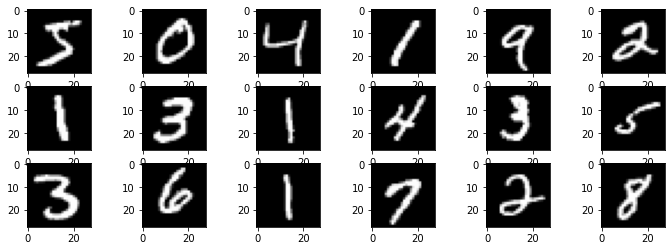

In [0]:
%matplotlib inline #use the "matplotlib inline" ipython "magic" function
# which allows "inline" plotting without needing to use plt.show()

# then load pyplot
import matplotlib.pyplot as plt

In [0]:
# visualize some of the examples
fig, axs = plt.subplots(nrows=3, ncols=6, constrained_layout=False, figsize=(12,4))
for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[i], cmap="gray")

To better visualize what is going on using the `enumerate` function above, print out the incrementor `i` and the axes handle `ax` on each loop through `axs.flat`, which 'flattens' the 2D (3 by 6) grid of subplots into a 1D vector of length 18 that can be iterated over

In [0]:
len(axs.flat)

18

In [0]:
for i, ax in enumerate(axs.flat):
   print(i)
   print(ax)

0
AxesSubplot(0.143347,0.657941;0.0740196x0.222059)
1
AxesSubplot(0.276204,0.657941;0.0740196x0.222059)
2
AxesSubplot(0.409062,0.657941;0.0740196x0.222059)
3
AxesSubplot(0.541919,0.657941;0.0740196x0.222059)
4
AxesSubplot(0.674776,0.657941;0.0740196x0.222059)
5
AxesSubplot(0.807633,0.657941;0.0740196x0.222059)
6
AxesSubplot(0.143347,0.391471;0.0740196x0.222059)
7
AxesSubplot(0.276204,0.391471;0.0740196x0.222059)
8
AxesSubplot(0.409062,0.391471;0.0740196x0.222059)
9
AxesSubplot(0.541919,0.391471;0.0740196x0.222059)
10
AxesSubplot(0.674776,0.391471;0.0740196x0.222059)
11
AxesSubplot(0.807633,0.391471;0.0740196x0.222059)
12
AxesSubplot(0.143347,0.125;0.0740196x0.222059)
13
AxesSubplot(0.276204,0.125;0.0740196x0.222059)
14
AxesSubplot(0.409062,0.125;0.0740196x0.222059)
15
AxesSubplot(0.541919,0.125;0.0740196x0.222059)
16
AxesSubplot(0.674776,0.125;0.0740196x0.222059)
17
AxesSubplot(0.807633,0.125;0.0740196x0.222059)


The above is one of many ways this data could be visualized using matplotlib. Another way to acheive the same result, with slightly less abstraction but one more line of code

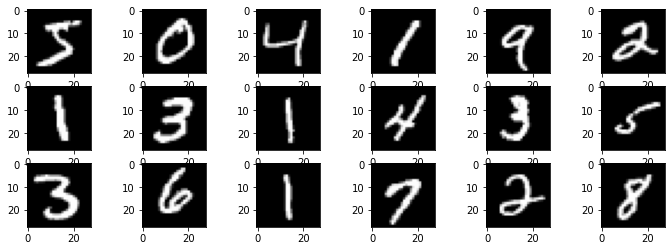

In [0]:
fig = plt.figure(constrained_layout=False, figsize=(12,4))
for i in range(18):
   ax = plt.subplot(3,6,i+1)
   ax.imshow(x_train[i], cmap="gray")

How many other different ways could you use matplotlib commands to create the same plot?

### Building an image classifier with Tensorflow 2 / keras

We can now build our model. The `model` is a deep neural network composed of two `dense` (or `fully connected`) layers. The model will receive a 28 x 28 pixel input which is "flattened" into a vector of size 784. Then, the first `Dense` layer will turn the 784 pixel value vector into 128 neuron or `node` activations, using a weight matrix of 128 x 784 and a bias matrix of 128, yielding a total of 100,480 parameters.

The second and final `Dense` layer is used for classification. It therefore has size 10 (the number of classes). It will turn the 128 activation values from the previous layer into a vector of probabilities of each class that sum to 1. We will use the `softmax` activation function 

We will also use a concept called `Dropout`, which is randomly dropping neurons at a certain rate (proportion of neurons dropped) to try to prevent the model from overfitting the data (memorizing the data rather than the general trend). We will use 0.2, which means 20% of our 100,480 parameters will be dropped

Dropout ensures that individual pairs of neurons don't develop an overly strong codependency, because those neurons could randomly drop out. Instead, image features important for classification are learned by groups of neurons or by multiple neuron-neuron pairings

You can either load all the layers you need into the namespace and call those functions individually using the following syntax:

In [0]:
from tensorflow.python.keras.layers import Dense, Flatten, Dropout, BatchNormalization

model = tf.keras.models.Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=10, activation='softmax'))

In the above, the initial model is made (a sequential model because it consist of layers, each of which follows from the other, receiving outputs from the previous layer and outputting into the next) and the layers are added using the `model.add` command

The [activation function](https://www.tensorflow.org/api_docs/python/tf/keras/activations) we are using is called `relu`, which is a nonlinear function known to be good for hidden layers in models for classification problems. The activation on the classifying layer is `softmax`, which provides a probability distribution of the likelihood of each of the digits


Another representation of exactly the same model could call the relevant `keras.layers` without loading them into the namespace

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

The `.summary()` command shows the model layers and how many trainable parameters there are. The larger that number, the larger the model. Larger numbers of parameters also tends to mean the model takes longer to train, and often that is more data hungry.

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Training the model

In order to use a model (for training, or later for testing on unseen images) it must be compiled. The following three arguments must be specified at a minimum:

1. The optimizer, which is the algorithm used to minimize the loss (that performs the gradient descent). Common optimizers include `adam`, `rsmprop`, and `sgd`.

2. The loss metric. This is the metric we will try to minimize through training. `sparse_categorical_crossentropy` is the same as `categorical_crossentropy` but the former takes the numeric labels (2, 5, 8, etc) directly rather than a one-hot encoded version of the label, so it is more convenient. One-hot encoding is creating a vector from a scalar integer by representing the scalar as `one hot digit`. For example, `0` would be represented

1 0 0 0 0 0 0 0 0 0

and `5` would be

0 0 0 0 0 1 0 0 0 0

3. Additional metrics, evaluated during training to provide further visibility of the model performance (they are not used in the optimization process itself, unlike `loss`)

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Training is acheived using the `.fit()` command. We'll use 10 epochs (a relatively small number for a deep learning project), meaning it will iterate over the whole train dataset 10 times

In [0]:
model.fit(x_train, y_train, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3001 - accuracy: 0.9121
Epoch 2/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1448 - accuracy: 0.9571
Epoch 3/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1095 - accuracy: 0.9667
Epoch 4/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0890 - accuracy: 0.9725
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0767 - accuracy: 0.9757
Epoch 6/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0662 - accuracy: 0.9790
Epoch 7/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0578 - accuracy: 0.9812
Epoch 8/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0526 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0491 - accuracy: 0.9834
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.044

Notice how the loss went progressively down and the accuracy increased steadily. This is the behavior you want to replicate with your projects. If the loss function starts to rise over successive epochs, something is wrong: abort model training and troubleshoot (hint: you may have chosen an inappropriate loss function for the task)

You could actually run the model for some more epochs and you should start to see a slight slow down in the rate of increase in accuracy (or decrease in loss)

In [0]:
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0410 - accuracy: 0.9864
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0377 - accuracy: 0.9871
Epoch 3/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0366 - accuracy: 0.9872
Epoch 4/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0353 - accuracy: 0.9879
Epoch 5/5
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0330 - accuracy: 0.9886


So, what is actually going on during model training?

1. Give the images to the network and collect the prediction (forward pass)
2. Evaluate the loss (how wrong the predictions are compared to the labels)
3. Adjust the network parameters (weights and biases) to reduce the loss, using the backpropagation algorithm (backward pass)
4. Repeat until the network converges, or the number of epochs has been reached

So how would we tell if a network has converged? One way would be to use more epochs and some criterion to stop the network given a threshold number of epochs the model has not improved over. This is called "early stopping"

That is what we implement below. 

In [0]:
from tensorflow.keras.callbacks import  EarlyStopping
earlystop = EarlyStopping(monitor="loss", mode="min", patience=15) 

The above says that we will stop the model early (i.e. before the max number of epochs) if the loss (`monitor=loss`, the loss of the validation subset) doesn't improve for 15 successive epochs (`patience= 15`)

Now we train like we did before, this time using `earlystop` as a callback function and too many epochs (we'll use 500)

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=500, callbacks = [earlystop])

Epoch 1/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3002 - accuracy: 0.9126
Epoch 2/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1450 - accuracy: 0.9563
Epoch 3/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1096 - accuracy: 0.9660
Epoch 4/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0892 - accuracy: 0.9724
Epoch 5/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0759 - accuracy: 0.9764
Epoch 6/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0680 - accuracy: 0.9781
Epoch 7/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0597 - accuracy: 0.9811
Epoch 8/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0541 - accuracy: 0.9817
Epoch 9/500
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0508 - accuracy: 0.9829
Epoch 10/500
1875/1875 [==============================] - 3s 2ms/step - l

We see that the model stopped training much earlier than 100 epochs because its loss converged to about 0.012 and wasn't improving further

Another useful function is to plot the training histories, that is the values of losses and metrics at the end of each

We'll make the model again, compile it, and fit for 50 epochs without early stopping. This time we'll make the output of `model.fit()` a variable called `history`

In [0]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=50)

Epoch 1/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2960 - accuracy: 0.9144
Epoch 2/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1412 - accuracy: 0.9577
Epoch 3/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.1058 - accuracy: 0.9686
Epoch 4/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0858 - accuracy: 0.9735
Epoch 5/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0722 - accuracy: 0.9774
Epoch 6/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0643 - accuracy: 0.9796
Epoch 7/50
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0571 - accuracy: 0.9818
Epoch 8/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0507 - accuracy: 0.9838
Epoch 9/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0490 - accuracy: 0.9838
Epoch 10/50
1875/1875 [==============================] - 4s 2ms/step - loss: 0.042

`history` is a specific keras object with attribute `history`, so let's see what data type `history.history` is

We see it is a dictionary object which means its internal variables are called `keys`

In [0]:
type(history.history)
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


We can then plot the loss and accuracy as a function of epoch

Text(0, 0.5, 'Model accuracy')

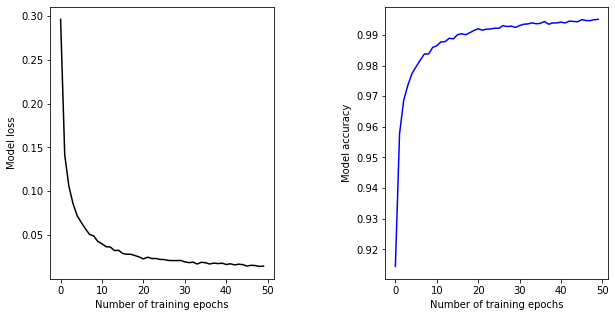

In [0]:
fig = plt.figure(figsize=(10,5)) #initialize a figure of a certain size
fig.subplots_adjust(wspace=0.5) #adjust them so there is 'width space' of 0.5 between adjacent subplots

# plot the loss history
plt.subplot(121)
plt.plot(history.history['loss'], 'k')
plt.xlabel("Number of training epochs")
plt.ylabel("Model loss")

# plot the accuracy history
plt.subplot(122)
plt.plot(history.history['accuracy'], 'b')
plt.xlabel("Number of training epochs")
plt.ylabel("Model accuracy")

The model displays classic exponential convergence towards its optimal. This doesn't always occur, especially for more complex data and classification tasks. Monitoring loss and metrics is therefore an important skill you'll want to apply to your own data and classification problems

### Evaluating model results

Perhaps the simplest way to do this is to use the in-built `.evaluate()` function on the test data

In [0]:
model.evaluate(x_test, y_test, verbose=0)

[0.11204781383275986, 0.9807999730110168]

We acheived an average loss of about 0.11 and an average accuracy of about 98%